In [1]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

sample_info = pd.read_csv('MOB_sample_info.csv', index_col=0)

df = pd.read_csv('data/Rep11_MOB_0.csv', index_col=0)
df = df.loc[sample_info.index]
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes

import NaiveDE

dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T

Populating the interactive namespace from numpy and matplotlib


In [2]:
results = pd.read_csv('MOB_final_results.csv', index_col=0)

results['pval'] = results['pval'].clip_lower(results.query('pval > 0')['pval'].min() / 2)
results['qval'] = results['qval'].clip_lower(results.query('qval > 0')['qval'].min() / 2)

sres = results.query('qval < 0.05 & g != "log_total_count"').copy()

X = sample_info[['x', 'y']].values
Y = res[sres['g']].values.T

In [3]:
import GPy
import GPclust

In [70]:
m = GPclust.MOHGP(X=X,
                  Y=Y,
                  kernF=GPy.kern.RBF(2) + GPy.kern.Bias(2),
                  kernY=GPy.kern.RBF(1) + GPy.kern.White(1),
                  K=5,
                  prior_Z='DP')

m.hyperparam_interval = 500

m.optimize(step_length=0.1, verbose=False)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    00s11  01   2.036520e+04   1.738152e+07 
    02s30  22   1.058517e+04   8.832406e+03 
Runtime:     02s30
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    01s21  11   9.345099e+03   1.073185e+03 
    02s42  22   9.317562e+03   1.049483e+04 
Runtime:     02s42
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    01s21  11   9.307972e+03   1.043838e+03 
    02s42  22   9.291670e+03   1.328869e+03 
Runtime:     02s42
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    00s12  01   9.271830e+03   7.873332e+02 
    02s52  23   9.242914e+03   2.429942e+04 
Runtime:     02s52
Optimization statu

    02s43  22   9.152680e+03   5.714786e+01 
Runtime:     02s43
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    01s16  10   9.152661e+03   1.687095e+00 
    02s51  22   9.140587e+03   1.761290e+04 
Runtime:     02s51
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    01s13  10   9.139023e+03   7.816363e-01 
    02s44  22   9.138913e+03   4.406649e-01 
Runtime:     02s44
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    00s88  08   9.138912e+03   7.438748e-03 
Runtime:     00s88
Optimization status: Converged



In [71]:
m

MOHGP.,value,constraints,priors
sum.rbf.variance,0.0803680564126,+ve,
sum.rbf.lengthscale,0.740931174309,+ve,
sum.bias.variance,23.7909356771,+ve,
sum_1.rbf.variance,5.63122121983,+ve,
sum_1.rbf.lengthscale,303.692860968,+ve,
sum_1.white.variance,0.137905813948,+ve,


In [72]:
m.phi_hat

array([  8.00000185,  13.        ,  11.        ,  24.99999815,  10.        ])

In [73]:
sres['cluster'] = m.phi_.argmax(1)
Cs = m.predict_components(X)

In [74]:
K_hat = len(sres.cluster.unique())
K_hat

5

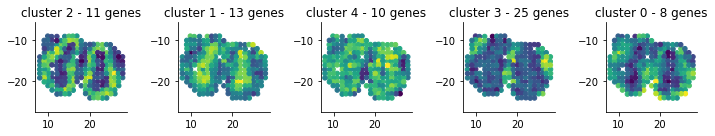

In [75]:
figsize(10, 2)
for i, Ci in enumerate(sres.cluster.unique()):
    C = Cs[0][Ci]
    plt.subplot(1, K_hat, i + 1)
    plt.scatter(X[:,0], -X[:,1], c=C, s=20)
    plt.axis('equal')
    plt.title('cluster {} - {} genes'.format(Ci, sres.query('cluster == @Ci').shape[0] ))
    
plt.tight_layout()

In [77]:
for i in sres.cluster.unique():
    print('Cluster {}'.format(i))
    print(', '.join(sres.g.loc[g.groups[i]].tolist()))

Cluster 2
Cpe, Cck, Doc2g, Slc1a2, Cdr1, Cdhr1, Gabra1, Slc6a11, Slc17a7, Rab3b, Trnp1
Cluster 1
Kcnh3, Mbp, Nrgn, Tubb2b, Pcp4, Penk, Gpsm1, Baiap2, Rbfox3, Arhgap33, Camk2b, Necab2, Ncdn
Cluster 4
Taf7l, Prokr2, 4933405L10Rik, Cplx1, Atp1b1, Tspan7, Pbx1, Gna14, Olfr635, Sfrp5
Cluster 3
Fabp7, Kif5b, Apod, Apoe, Apc, Marcks, Kctd12, Ptn, Mcf2l, S100a5, Omp, Scd1, Lpar1, Trak2, Igfbp5, Nr2f2, Ccnd1, Unc13c, Sash1, Frzb, Gng13, Sorbs1, Foxd3, Vtn, Pmepa1
Cluster 0
Sparcl1, Glul, Nrsn1, Sepp1, Igfbp2, Aqp4, Ptgds, Igf1
